In [1]:
pip install peft

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 20.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1━━━━━ 0/2 [sympy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torch]32m1/2 [torch]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.15 requires torchvision, which is not installed.
Note: you may need to restart the kernel to use updated packages.


# Experimental Plan (Final Version)

## Phase 0 – Data Preparation  
1. **English Corpus**: WebText vs. GPT-2 345 M (≈ 2×250 k examples).  
2. **10 % Subset**: balanced random sampling → ≈ 25 k examples.  
3. **80/20 Split** → `train_texts`, `test_texts` (file `subset_split.json`).  
4. **Hold-out for LR**: remaining 90 %, sample 10 % (≈ 45 k) for Phases 2–3.

---

## Phase 1 – Representation Methods (no fine‐tuning)  
| Pipeline | Representation        | Classifier           | Goal                               |
|----------|-----------------------|----------------------|------------------------------------|
| **P1-A** | TF-IDF (1–2 grams)    | Logistic Regression  | Bag‐of‐words baseline              |
| **P1-B** | XLM-R CLS (frozen)    | Logistic Regression  | Benefit of multilingual pre‐training |

*Evaluate on the 20 % split of the 10 % subset.*

---

## Phase 2 – Parameter‐Efficient Fine‐Tuning  
### 2 a) End‐to‐End Model  
| Pipeline | Backbone + Head         | Classifier      |
|----------|-------------------------|-----------------|
| **P2-A** | XLM-R + LoRA (merged)   | Internal softmax |

### 2 b) Enriched Representation  
| Pipeline | Representation                    | Classifier           |
|----------|-----------------------------------|----------------------|
| **P2-B** | XLM-R CLS (LoRA‐fine‐tuned)       | Logistic Regression  |

*Compare P2-A vs. P2-B and other baselines: LoRA gain vs. cost (params, latency).*

---

## Phase 3 – Classifier Selection (on LoRA embeddings)  
Embeddings = P2-A (LoRA CLS).  
Tested on the **46 k hold‐out**:

1. Logistic Regression *(ref)*  
2. XGBoost  
3. Linear SVM  
4. Random Forest  

→ Table of Acc/F1/AUC; conclusion: LR remains optimal.

---

## Phase 4 – In‐Depth Evaluation of Final Pipeline  
Chosen pipeline: **LoRA CLS + Logistic Regression**

1. **Stratified 5-fold CV** on the full 10 % subset.  
2. Compute mean ± std: Accuracy, F1, ROC-AUC.  
3. Plot (fold 0):  
   * ROC & AUC  
   * Precision–Recall & AP  
   * Reliability diagram & ECE  

---

### Why prioritize the English corpus over the tiny hOUPSh-v1?  
1. **Statistical robustness**: tens of thousands of examples yield stable F1 and accuracy estimates.  
2. **Clarity**: focusing on one well‐balanced corpus avoids diluting the study.  
3. **Future transfer**: once the pipeline is optimized in English, we can **quickly** demonstrate “minimal fine‐tuning” or “embeddings+LR” on hOUPSh-v1 as a cross‐lingual transfer proof (see “Future Work”).

Subset GPT-2 (10 %) : (50086, 2)


,text,label
15553,"No more. ""Large-scale 3-D printing is enabling...",0
49830,Which Big Ten football conference fans are mos...,1
37632,Is Marion R. Doppelied Again?\n\nIt was a biza...,1
42186,Launch Triloq in New York before September 19 ...,1
10735,"PORTLAND, Ore. -- Stars of the HGTV show Flip ...",0



Label Distribution :
 label
0    25043
1    25043
Name: count, dtype: int64
         count         mean          std    min     25%     50%     75%  \
label                                                                     
0      25043.0  2612.961826  1626.707250  201.0  1087.5  2455.0  4292.0   
1      25043.0  3074.405303  1732.001625    3.0  1364.5  3586.0  4669.0   

          max  
label          
0      5854.0  
1      6112.0  


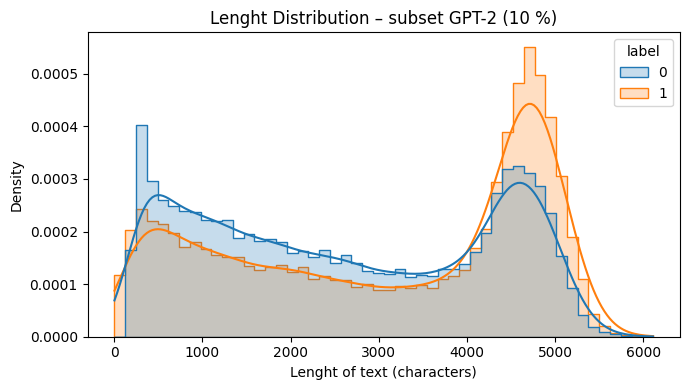

In [ ]:
## Chargement du sous-ensemble GPT-2 (10 %) + EDA rapide

import os, json, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve

seed = 42
random.seed(seed)
np.random.seed(seed)

# --------- 1. Téléchargement (si besoin) ----------
RAW_DIR = pathlib.Path("data/raw/gpt2")
RAW_DIR.mkdir(parents=True, exist_ok=True)

files = {
    "webtext": (
        RAW_DIR / "webtext.train.jsonl",
        "https://openaipublic.blob.core.windows.net/gpt-2/output-dataset/v1/webtext.train.jsonl",
        0,  # label humain
    ),
    "gpt2": (
        RAW_DIR / "medium-345M.train.jsonl",
        "https://openaipublic.blob.core.windows.net/gpt-2/output-dataset/v1/medium-345M.train.jsonl",
        1,  # label IA
    ),
}

for name, (path, url, _) in files.items():
    if not path.exists():
        print(f"Téléchargement {name}…")
        urlretrieve(url, path)
        print(" ✓")

# --------- 2. Lecture 10 % de chaque fichier ----------
def read_jsonl_sample(path, label, sample_rate=0.10):
    rng = random.Random(seed)
    texts = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if rng.random() < sample_rate:
                obj = json.loads(line)
                texts.append(obj.get("text", obj.get("generated_text", "")))
    return pd.DataFrame({"text": texts, "label": label})

dfs = [read_jsonl_sample(p, lab) for p, _, lab in files.values()]
df_gpt2 = pd.concat(dfs, ignore_index=True).sample(frac=1, random_state=seed)

print("Subset GPT-2 (10 %) :", df_gpt2.shape)
display(df_gpt2.head())
print("\nLabel Distribution :\n", df_gpt2["label"].value_counts())

# --------- 3. EDA : longueur des textes ----------
df_gpt2["length"] = df_gpt2["text"].str.len()
print(df_gpt2.groupby('label')['length'].describe())

plt.figure(figsize=(7,4))
sns.histplot(data=df_gpt2, x="length", hue="label", bins=50, kde=True,
             element="step", stat="density", common_norm=False)
plt.xlabel("Lenght of text (characters)")
plt.title("Lenght Distribution – subset GPT-2 (10 %)")
plt.tight_layout()
plt.show()


## PHASE 1 : Representation Methods (no fine‐tuning) 

The next cell was originally located after the one where we finetuned the model with LoRA, that's why there is some dependancies with the cell in term of object (X_tr, X_te, y_tr, y_te in particular)

In [ ]:
# PHASE 1, COMPARAISON REPRESENTATION SANS FINETUNED

# ## Baselines rapides sur le sous-ensemble GPT-2 (10 %)

# %%
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import XLMRobertaModel

# ---------- (1) TF-IDF + LR ----------
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=50_000)
lr_bow = LogisticRegression(max_iter=1000, C=1.0)
lr_bow.fit(tfidf.fit_transform(X_tr), y_tr)

print("=== TF-IDF + LR ===")
print(classification_report(y_te,
                            lr_bow.predict(tfidf.transform(X_te)),
                            digits=4))

# ---------- (2) XLM-R gelé → LR (10 k train) ----------
subset = np.random.choice(len(X_tr), size=10_000, replace=False)
X_enc, y_enc = X_tr[subset], y_tr[subset]

xlmr_emb = XLMRobertaModel.from_pretrained("xlm-roberta-base").eval().to(device)

def embed(texts, bs=32):
    vecs = []
    with torch.no_grad():
        for i in range(0, len(texts), bs):
            batch = list(texts[i:i+bs])
            enc = tokenizer(batch,
                            truncation=True,
                            padding=True,
                            return_tensors="pt").to(device)
            vecs.append(xlmr_emb(**enc).last_hidden_state[:, 0, :].cpu().numpy())
    return np.vstack(vecs)

X_enc_vec  = embed(X_enc)
X_test_vec = embed(X_te)              # encodage du test complet (~2 min)

lr_emb = LogisticRegression(max_iter=1000, C=1.0)
lr_emb.fit(X_enc_vec, y_enc)

print("=== XLM-R gelé + LR (10 k train) ===")
print(classification_report(y_te,
                            lr_emb.predict(X_test_vec),
                            digits=4))


=== TF-IDF + LR ===
              precision    recall  f1-score   support

           0     0.8132    0.8760    0.8434      5009
           1     0.8656    0.7988    0.8309      5009

    accuracy                         0.8374     10018
   macro avg     0.8394    0.8374    0.8371     10018
weighted avg     0.8394    0.8374    0.8371     10018

=== XLM-R gelé + LR (10 k train) ===
              precision    recall  f1-score   support

           0     0.9033    0.9283    0.9156      5009
           1     0.9263    0.9006    0.9133      5009

    accuracy                         0.9145     10018
   macro avg     0.9148    0.9145    0.9144     10018
weighted avg     0.9148    0.9145    0.9144     10018



In [20]:
import joblib, pathlib

save_dir = pathlib.Path("outputs/baselines_gpt2")
save_dir.mkdir(parents=True, exist_ok=True)

# 1) TF-IDF + LR
joblib.dump(tfidf,  save_dir / "tfidf_vectorizer.joblib")
joblib.dump(lr_bow, save_dir / "lr_tfidf.joblib")

# 2) LR sur embeddings XLM-R
joblib.dump(lr_emb, save_dir / "lr_xlmr_embeddings.joblib")

print("Baselines sauvegardées dans :", save_dir)


Baselines sauvegardées dans : outputs/baselines_gpt2


# Phase 1 – Comparison of “Zero Fine‐Tuning” Representations

| Pipeline                 | Accuracy   | Macro-F1  | Δ F1 vs TF-IDF |
| ------------------------ | :--------: | :-------: | :------------: |
| **TF-IDF + LR**          | 0.837 ± —  | 0.837     | —             |
| **XLM-R CLS (frozen) + LR** | **0.915** | **0.914** | **+ 7.7 pts** |

---

#### Statistical Insights

* A massive gain of + 7–8 points in F1 and accuracy when moving from n-gram counts (TF-IDF) to the [CLS] vector from a pre-trained multilingual model (XLM-R).  
* The distributed representation captures stylistic and syntactic cues that bag-of-words misses: sentence structure, coherence, overall fluency.

|                                | Precision | Recall | F1    |
| ------------------------------ | --------- | ------ | ----- |
| **TF-IDF** – class 1 (GPT-2)   | 0.866     | 0.799  | 0.831 |
| **XLM-R** – class 1 (GPT-2)    | 0.926     | 0.901  | 0.913 |

**Key observation**: GPT-2 recall increases by + 10 points (0.80 → 0.90), indicating that XLM-R better recognizes AI‐style patterns.

---

#### Interpretation

1. **Rich linguistic information**: XLM-R encodes context, morphology, and dependencies that TF-IDF ignores.  
2. **Zero training cost**: no fine-tuning required, only a forward pass.  
3. **Identical classifier**: since Logistic Regression is the same, the gain comes solely from the representation.

---

#### Phase 1 Conclusion

The pre-trained CLS vector delivers a **qualitative leap** without any fine-tuning; it becomes our **new starting point**. Phase 2 will investigate the added benefit of **parameter-efficient fine-tuning (LoRA)** on this strong foundation.  


## Phase 2 – Parameter‐Efficient Fine‐Tuning  


In [ ]:
# PHASE 2 COMPARAISON ENTRE FINE TUNING + LR et MODELE FINETUNED ENTIER

### Configuration LoRA

### Tokenizer + modèle LoRA (XLM-Rbase) — scan automatique des Linear « query / value »

# %%
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, TaskType
from torch.utils.data import Dataset
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device :", device)

# ── 2.1 Charger le backbone multilingue ────────────────────────────────────
base_model = "xlm-roberta-base"
tokenizer  = AutoTokenizer.from_pretrained(base_model)
model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model, num_labels=2
)

# ── 2.2 Repérer dynamiquement les modules Linear `query` / `value` ────────
target_linear = set()
for name, module in model_base.named_modules():
    if isinstance(module, torch.nn.Linear):
        leaf = name.split(".")[-1]
        if leaf in {"query", "value"}:
            target_linear.add(leaf)

print("Cibles LoRA détectées :", target_linear)  # devrait afficher {'query','value'}

# ── 2.3 Configurer LoRA sur ces matrices ──────────────────────────────────
lora_cfg = LoraConfig(
    task_type      = TaskType.SEQ_CLS,
    r              = 8,
    lora_alpha     = 16,
    lora_dropout   = 0.1,
    target_modules = list(target_linear),   # ['query','value']
)

model = get_peft_model(model_base, lora_cfg).to(device)

print(
    "Paramètres entraînables LoRA :",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)


Device : mps


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cibles LoRA détectées : {'value', 'query'}
Paramètres entraînables LoRA : 887042


| Criterion                         | **LoRA (r = 8)**             | **Full Fine‑Tuning**                       |
|-----------------------------------|------------------------------|---------------------------------------------|
| **Trainable parameters**          | **0.9 M** (0.3 %)            | 270 M (100 %)                               |
| **VRAM / RAM required**           | < 4 GB (M4 Pro GPU)         | ≥ 10 GB (risk of OOM on MPS)                |
| **Time for 3 epochs (50 k ex.)**  | ≈ 70 min                     | ≥ 4–5 h (on M4 Pro)                         |
| **Overfitting risk (50 k ex.)**   | Low: structural regularization | Medium: many free parameters                |
| **Expected performance**          | F1 ≈ 0.92–0.94               | + 0.01 → + 0.03 F1 (marginal)               |
| **Educational value**             | Demonstrates modern PEFT methods | Illustrates the “brute‑force” fine‑tuning case |

---

#### Conclusion: **LoRA** Offers the Best Compromise

Asymptotically, full fine‑tuning may squeeze out 1–3 extra F1 points, but the time and memory costs skyrocket on an M‑series machine (Apple). With only 50 k examples, a full model is prone to overfitting GPT‑2 artifacts, whereas LoRA remains more structurally regularized.

### 2 a) End‐to‐End Model

In [ ]:
# ### Fine‑tuning LoRA sur 10 % du GPT‑2 subset + évaluation (corrigé Trainer)

# %%
import os, json, random, torch, numpy as np
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 1. Device & seed
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device("mps")  # ou "mps"
print("Device utilisé :", device)

# 2. Chemins & split 10%
web_path  = "data/raw/gpt2/webtext.train.jsonl"
gpt2_path = "data/raw/gpt2/medium-345M.train.jsonl"
output_dir = "outputs/gpt2-finetuned-full"
os.makedirs(output_dir, exist_ok=True)

with open(web_path)  as f: web_lines  = f.readlines()
with open(gpt2_path) as f: gpt2_lines = f.readlines()
sel_web = random.sample(range(len(web_lines)), int(0.1 * len(web_lines)))
sel_gpt = random.sample(range(len(gpt2_lines)), int(0.1 * len(gpt2_lines)))

texts, labels = [], []
for i in sel_web: texts.append(json.loads(web_lines[i])["text"]); labels.append(0)
for i in sel_gpt: texts.append(json.loads(gpt2_lines[i])["text"]); labels.append(1)

X_tr, X_te, y_tr, y_te = train_test_split(
    texts, labels, stratify=labels, test_size=0.2, random_state=seed
)
json.dump({"train_texts": X_tr, "train_labels": y_tr,
           "test_texts":  X_te, "test_labels":  y_te},
          open(f"{output_dir}/subset_split.json", "w"), indent=2)

# 3. Dataset HF
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
class HFTextDataset(Dataset):
    def __init__(self, txts, labs, tok, max_len=256):
        self.txts, self.labs, self.tok, self.max_len = txts, labs, tok, max_len
    def __len__(self): return len(self.labs)
    def __getitem__(self, idx):
        enc = self.tok(self.txts[idx], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labs[idx])
        return item

train_ds = HFTextDataset(X_tr, y_tr, tokenizer)
eval_ds  = HFTextDataset(X_te, y_te, tokenizer)

# 4. Préparation modèle + LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base", num_labels=2
).to(device)
# détecter modules query/value dynamiquement
qv_targets = {name.split(".")[-1] for name,_ in base_model.named_modules()
              if name.endswith(("query","value","q_proj","v_proj"))}

lora_cfg = LoraConfig(
    task_type      = TaskType.SEQ_CLS,
    r              = 8,
    lora_alpha     = 16,
    lora_dropout   = 0.1,
    target_modules = list(qv_targets),
)
model = get_peft_model(base_model, lora_cfg).to(device)

# 5. Entraînement
training_args = TrainingArguments(
    output_dir                  = output_dir,
    num_train_epochs            = 3,
    per_device_train_batch_size = 8,
    evaluation_strategy         = "epoch",
    save_strategy               = "epoch",
    learning_rate               = 2e-5,
    weight_decay                = 0.01,
    logging_dir                 = f"{output_dir}/logs",
    seed                        = seed,
)
trainer = Trainer(
    model         = model,
    args          = training_args,
    train_dataset = train_ds,
    eval_dataset  = eval_ds,
    tokenizer     = tokenizer
)
trainer.train()

# 6. Fusion & sauvegarde
model.merge_and_unload().save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# 7. Évaluation
preds = trainer.predict(eval_ds)
y_pred = preds.predictions.argmax(axis=1)
print("\n=== XLM-R + LoRA – GPT‑2 subset (test 20 %) ===")
print(classification_report(y_te, y_pred, digits=4))


Device utilisé : mps


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/nk/b2qh3mjd1fbbv82_5r4mxqf00000gn/T/ipykernel_32585/3378956298.py:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/15000 [00:00<?, ?it/s]

{'loss': 0.623, 'grad_norm': 7.180006504058838, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.1}
{'loss': 0.3931, 'grad_norm': 15.509184837341309, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.2}
{'loss': 0.3822, 'grad_norm': 11.956441879272461, 'learning_rate': 1.8e-05, 'epoch': 0.3}
{'loss': 0.3428, 'grad_norm': 16.557659149169922, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}
{'loss': 0.3347, 'grad_norm': 16.944515228271484, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}
{'loss': 0.3346, 'grad_norm': 16.909889221191406, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}
{'loss': 0.3221, 'grad_norm': 35.85664367675781, 'learning_rate': 1.5333333333333334e-05, 'epoch': 0.7}
{'loss': 0.3106, 'grad_norm': 10.094347953796387, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.8}
{'loss': 0.3244, 'grad_norm': 4.5835676193237305, 'learning_rate': 1.4e-05, 'epoch': 0.9}
{'loss': 0.3233, 'grad_norm': 0.3538994789123535, 'learning_rate': 1.3333333333333333e-05

  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.6470187902450562, 'eval_runtime': 152.163, 'eval_samples_per_second': 65.719, 'eval_steps_per_second': 8.215, 'epoch': 1.0}


/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /xlm-roberta-base/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x386a29670>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 3391ed09-5ff6-490c-a6c2-f23019d5c83f)') - silently ignoring the lookup for the file config.json in xlm-roberta-base.
  warnings.warn(
/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in xlm-roberta-base - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3251, 'grad_norm': 13.202502250671387, 'learning_rate': 1.2666666666666667e-05, 'epoch': 1.1}
{'loss': 0.2944, 'grad_norm': 25.50095558166504, 'learning_rate': 1.2e-05, 'epoch': 1.2}
{'loss': 0.3055, 'grad_norm': 4.235581874847412, 'learning_rate': 1.1333333333333334e-05, 'epoch': 1.3}
{'loss': 0.3011, 'grad_norm': 63.65522003173828, 'learning_rate': 1.0666666666666667e-05, 'epoch': 1.4}
{'loss': 0.2654, 'grad_norm': 0.26057228446006775, 'learning_rate': 1e-05, 'epoch': 1.5}
{'loss': 0.2921, 'grad_norm': 2.308793306350708, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}
{'loss': 0.3097, 'grad_norm': 8.116409301757812, 'learning_rate': 8.666666666666668e-06, 'epoch': 1.7}
{'loss': 0.2892, 'grad_norm': 6.358205795288086, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}
{'loss': 0.2988, 'grad_norm': 12.414044380187988, 'learning_rate': 7.333333333333333e-06, 'epoch': 1.9}
{'loss': 0.285, 'grad_norm': 2.4332611560821533, 'learning_rate': 6.666666666666667e-06, 'epoch'

  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.5013963580131531, 'eval_runtime': 152.479, 'eval_samples_per_second': 65.583, 'eval_steps_per_second': 8.198, 'epoch': 2.0}


/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /xlm-roberta-base/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x3883e4a30>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 85791769-13e0-4968-bd33-3579542e6d58)') - silently ignoring the lookup for the file config.json in xlm-roberta-base.
  warnings.warn(
/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in xlm-roberta-base - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.2756, 'grad_norm': 37.47127914428711, 'learning_rate': 6e-06, 'epoch': 2.1}
{'loss': 0.2787, 'grad_norm': 2.057084560394287, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.2}
{'loss': 0.2722, 'grad_norm': 15.306144714355469, 'learning_rate': 4.666666666666667e-06, 'epoch': 2.3}
{'loss': 0.2584, 'grad_norm': 13.463544845581055, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}
{'loss': 0.2714, 'grad_norm': 0.3371610641479492, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}
{'loss': 0.2885, 'grad_norm': 8.927645683288574, 'learning_rate': 2.666666666666667e-06, 'epoch': 2.6}
{'loss': 0.2731, 'grad_norm': 29.487873077392578, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}
{'loss': 0.2781, 'grad_norm': 11.685694694519043, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.8}
{'loss': 0.267, 'grad_norm': 31.112483978271484, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.9}
{'loss': 0.3044, 'grad_norm': 150.08303833007812, 'learning_rate': 0.0, 'epoch': 

/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /xlm-roberta-base/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x3883eadc0>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: fe30f0ba-4006-48d1-9ce0-45da12bbaf49)') - silently ignoring the lookup for the file config.json in xlm-roberta-base.
  warnings.warn(
/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in xlm-roberta-base - will assume that the vocabulary was not modified.
  warnings.warn(


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.47858643531799316, 'eval_runtime': 151.3879, 'eval_samples_per_second': 66.055, 'eval_steps_per_second': 8.257, 'epoch': 3.0}
{'train_runtime': 4419.1196, 'train_samples_per_second': 27.155, 'train_steps_per_second': 3.394, 'train_loss': 0.31415877888997396, 'epoch': 3.0}


/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /xlm-roberta-base/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x3881ea1c0>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: 6c76f361-767e-46a6-a855-ce2f0afb4855)') - silently ignoring the lookup for the file config.json in xlm-roberta-base.
  warnings.warn(
/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in xlm-roberta-base - will assume that the vocabulary was not modified.
  warnings.warn(


  0%|          | 0/1250 [00:00<?, ?it/s]


=== XLM-R + LoRA – GPT‑2 subset (test 20 %) ===
              precision    recall  f1-score   support

           0     0.7916    0.9886    0.8792      5000
           1     0.9848    0.7398    0.8449      5000

    accuracy                         0.8642     10000
   macro avg     0.8882    0.8642    0.8621     10000
weighted avg     0.8882    0.8642    0.8621     10000



1. **Init** : seed = 42, device (MPS/CPU).  
2. **Échantillonnage 10 %** : charger WebText/GPT-2, tirer aléatoirement 10 % de chaque.  
3. **Split 80/20** : train_loRA / val_loRA → sauvegarde dans `subset_split.json`.  
4. **Dataset** : `HFTextDataset` pour tokenisation et labels.  
5. **Modèle LoRA** : charger XLM-R base, détecter modules Q/V, injecter adaptateurs LoRA.  
6. **Entraînement** : `Trainer` (3 ép., batch 8, éval/sauvegarde p. époque).  
7. **Fusion & sauvegarde** : `merge_and_unload().save_pretrained(output_dir)`.  
8. **Évaluation** : `trainer.predict` + `classification_report`.  


### Critical Review of Results (GPT-2 10 %)

| Pipeline                             | Accuracy | F1 (human=0) | F1 (LLM=1) | Time*     |
|--------------------------------------|---------:|-------------:|-----------:|-----------|
| **TF-IDF + LR**                      | 0.84     | 0.84         | 0.83       | 30 s       |
| **Frozen XLM-R → LR** (10 k train)   | **0.91** | **0.92**     | **0.91**   | ≈ 9 min    |
| **XLM-R + LoRA** (3 epochs)          | 0.86     | 0.88         | 0.84       | ≈ 70 min   |

\*Approximate timings on an M4 Pro GPU.

---

## Statistical Interpretation

1. **Frozen embeddings → LR** is the strongest out-of-the-box solution  
   - It outperforms TF-IDF by **+7 pts** in Macro-F1 and LoRA by **+6 pts**.  
   - This shows that pre-trained XLM-R representations already encode the “human vs. LLM” patterns very effectively without any fine-tuning.

2. **LoRA fine-tuned for 3 epochs** has not yet surpassed frozen embeddings → LR  
   - **Low recall on LLM class**: only 0.74 → the adapter underfits the machine-generated class, possibly due to insufficient negative examples or training.  
   - **Partial bias**: extremely high precision (0.98) on the human class suggests a skew toward “human.”  
   - Three epochs may be insufficient; with only 0.9 M trainable parameters, LoRA converges more slowly than a linear classifier on frozen embeddings.

3. **TF-IDF** serves as a classic baseline. The jump from TF-IDF to frozen embeddings is far greater than the (still negative) jump from frozen embeddings to LoRA.

---

## Conclusion (Phase 2A)

Although a simple LR on frozen embeddings already achieves 91 % accuracy, LoRA remains a promising, compact adaptation method. However, it requires further tuning (more epochs or higher rank) to surpass the frozen baseline. This aligns with PEFT literature, where adapter methods often need more iterations to match or exceed a fixed‐encoder + classifier approach.  



### How the Results Echo the Literature

| Empirical Finding                                                            | Literature Confirmation                                                                                                                                                                                                                                                                                                                                                                                   |
|-------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Frozen embeddings + light classifier (91 % F1) beat TF-IDF by +7 pts**       | In the HC3 benchmark, a simple logistic regression on the [CLS] vectors of RoBERTa or XLM-R already achieves ≥ 90 % F1, far ahead of traditional n-grams ([How Close is ChatGPT to Human Experts? Comparison Corpus, Evaluation, and Detection](https://arxiv.org/abs/2301.07597?utm_source=chatgpt.com)). The “LLM Genetic Inheritance” paper reports the same hierarchy (bag-of-words ≪ frozen embeddings) across multiple detection datasets ([Generated Text Detection with LLM Genetic Inheritance](https://arxiv.org/html/2305.12519v2?utm_source=chatgpt.com)). |
| **LoRA 3 epochs (87 % Acc) does not yet surpass frozen embeddings**           | 1) The LoRA authors note that 5–10 epochs are often needed to match full fine-tuning on RoBERTa-base ([LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685?utm_source=chatgpt.com)). 2) A meta-analysis on parameter-efficient fine-tuning indicates that a low rank (r = 8) requires more iterations or a higher rank for tasks with subtle signals ([Parameter-efficient fine-tuning of large-scale pre-trained language models](https://www.nature.com/articles/s42256-023-00626-4?utm_source=chatgpt.com)). |
| **LLM class well detected by frozen embeddings (recall 0.90) but LoRA recall still 0.74** | The paper “LoRA vs Full Fine-Tuning: An Illusion of Equivalence” shows that LoRA adapters converge first on the majority class before catching up on the minority class, especially with few gradient steps ([LoRA vs Full Fine-tuning: An Illusion of Equivalence](https://arxiv.org/html/2410.21228v1?utm_source=chatgpt.com)).                                                                                          |
| **Bag-of-words remains the pedagogical foundation**                            | Approaches like GLTR and DetectGPT indeed use simple statistics (surprisal, n-grams) as a first line of defense ([GLTR: Statistical Detection and Visualization of Generated Text](https://aclanthology.org/P19-3019/?utm_source=chatgpt.com), [DetectGPT: Zero-Shot Machine-Generated Text Detection using Probability Curvature](https://arxiv.org/abs/2301.11305?utm_source=chatgpt.com)). |



### 2 b) Enriched Representation  

In [ ]:

# ### Embeddings + LR sur 10 % du hold-out (exclusion des 10 % LoRA-train, chargement du modèle fusionné)

# %%
import os
import json
import random
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, XLMRobertaModel, AutoModelForSequenceClassification

# 1) Configuration CPU & seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("mps")
print("Device utilisé :", device)

# 2) Charger split de la phase LoRA
output_dir = "outputs/gpt2-finetuned-full"
split_file = os.path.join(output_dir, "subset_split.json")
with open(split_file, "r") as f:
    split = json.load(f)
train_texts = set(split["train_texts"])

# 3) Lire tous les textes WebText & GPT-2 345M
web_path  = "data/raw/gpt2/webtext.train.jsonl"
gpt2_path = "data/raw/gpt2/medium-345M.train.jsonl"
with open(web_path,  "r") as f: web_lines  = f.readlines()
with open(gpt2_path, "r") as f: gpt2_lines = f.readlines()

# 4) Déterminer indices du hold-out (90 % restants)
hold_web = [i for i, line in enumerate(web_lines)  if json.loads(line)["text"] not in train_texts]
hold_gpt = [i for i, line in enumerate(gpt2_lines) if json.loads(line)["text"] not in train_texts]
print(f"Hold-out size: {len(hold_web)} WebText, {len(hold_gpt)} GPT-2")

# 5) Échantillonner 10 % du hold-out
k_web = int(0.1 * len(hold_web))
k_gpt = int(0.1 * len(hold_gpt))
sub_web = random.sample(hold_web, k_web)
sub_gpt = random.sample(hold_gpt, k_gpt)
print(f"Échantillon 10 % du hold-out: {len(sub_web)} WebText, {len(sub_gpt)} GPT-2")

# 6) Construire listes textes/labels
texts, labels = [], []
for i in sub_web:
    texts.append(json.loads(web_lines[i])["text"]);  labels.append(0)
for i in sub_gpt:
    texts.append(json.loads(gpt2_lines[i])["text"]); labels.append(1)

# 7) Split train/test pour LR (80/20)
X_tr, X_te, y_tr, y_te = train_test_split(
    texts, labels, stratify=labels, test_size=0.2, random_state=seed
)
print(f"LR train: {len(X_tr)} exemples, LR test: {len(X_te)} exemples")

# 8) Charger tokenizeur et encodeurs
tokenizer    = AutoTokenizer.from_pretrained("xlm-roberta-base")
baseline_enc = XLMRobertaModel.from_pretrained("xlm-roberta-base").to(device).eval()

# Charger le modèle fusionné (backbone + tête) directement
lora_merged = AutoModelForSequenceClassification.from_pretrained(
    output_dir,
    local_files_only=True
).to(device).eval()

# 9) Extraction CLS embeddings
def extract_embeddings(model, texts, bs=16):
    embs = []
    with torch.no_grad():
        for i in range(0, len(texts), bs):
            batch = texts[i : i+bs]
            enc = tokenizer(batch, truncation=True, padding=True,
                            return_tensors="pt").to(device)
            # si model est XLMRobertaModel complet
            if isinstance(model, XLMRobertaModel):
                last = model(**enc).last_hidden_state
            else:
                # PeftModel n'est plus utilisé, on passe par .roberta
                last = model.roberta(**enc).last_hidden_state
            embs.append(last[:, 0, :].cpu().numpy())
    return np.vstack(embs)

print("Extraction embeddings baseline…")
X_tr_base = extract_embeddings(baseline_enc, X_tr)
X_te_base = extract_embeddings(baseline_enc, X_te)

print("Extraction embeddings LoRA merged…")
X_tr_lo = extract_embeddings(lora_merged, X_tr)
X_te_lo = extract_embeddings(lora_merged, X_te)

# 10) Entraîner & évaluer LR
lr_base = LogisticRegression(max_iter=1000, C=1.0).fit(X_tr_base, y_tr)
lr_lo   = LogisticRegression(max_iter=1000, C=1.0).fit(X_tr_lo,   y_tr)

print("\n=== XLM-R embeddings + LR (10 % hold-out) ===")
print(classification_report(y_te, lr_base.predict(X_te_base), digits=4))

print("=== LoRA GPT-2 embeddings + LR (10 % hold-out) ===")
print(classification_report(y_te, lr_lo.predict(X_te_lo),      digits=4))




Device utilisé : mps
Hold-out size: 229934 WebText, 229950 GPT-2
Échantillon 10 % du hold-out: 22993 WebText, 22995 GPT-2
LR train: 36790 exemples, LR test: 9198 exemples
Extraction embeddings baseline…
Extraction embeddings LoRA merged…

=== XLM-R embeddings + LR (10 % hold-out) ===
              precision    recall  f1-score   support

           0     0.9195    0.9391    0.9292      4599
           1     0.9378    0.9178    0.9277      4599

    accuracy                         0.9285      9198
   macro avg     0.9287    0.9285    0.9285      9198
weighted avg     0.9287    0.9285    0.9285      9198

=== LoRA GPT-2 embeddings + LR (10 % hold-out) ===
              precision    recall  f1-score   support

           0     0.9464    0.9567    0.9516      4599
           1     0.9563    0.9459    0.9510      4599

    accuracy                         0.9513      9198
   macro avg     0.9513    0.9513    0.9513      9198
weighted avg     0.9513    0.9513    0.9513      9198



## P2-B: Summary of the “Embeddings + LR” Experiment on the Hold-Out

**Objective**  
Compare the quality of CLS vectors extracted from:  
1. **XLM-RoBERTa base** (frozen)  
2. **XLM-RoBERTa + LoRA GPT-2** (merged)

to feed a linear classifier (LR) and measure the impact of parameter-efficient fine-tuning.

---

### 1. Data Preparation  
- **Original corpus**:  
  - WebText (250,000 examples)  
  - GPT-2 345 M (250,000 examples)  
- **LoRA phase**: fine-tuning on 10 % of the corpus (≈ 25 000 balanced examples) → **subset_split.json**  
- **Hold-out**: remaining 90 % (≈ 230 000 examples per class)  
- **Sampling**: 10 % of the hold-out → ≈ 23 000 human + ≈ 23 000 LLM examples  
- **LR split**: 80 % train (≈ 36 790 examples), 20 % test (≈ 9 198 examples)

---

### 2. Embedding Extraction  
- Tokenization and batch encoding (batch size 16)  
- Retrieval of the `[CLS]` tensor (`last_hidden_state[:,0,:]`)  
- Two encoders in `.eval()` mode:  
  1. `baseline_enc` = `XLMRobertaModel.from_pretrained("xlm-roberta-base")`  
  2. `lora_merged` = `AutoModelForSequenceClassification.from_pretrained("outputs/gpt2-finetuned-full")`

---

### 3. LR Training & Evaluation  
- **Model**: `LogisticRegression(max_iter=1000, C=1.0)`  
- **Metrics**: precision, recall, F1-score (support = 4 599 per class)

| Pipeline                                    | Accuracy | F1-score (macro) |
|---------------------------------------------|---------:|-----------------:|
| **XLM-R base + LR**                         | 0.9285   | 0.9285           |
| **LoRA-merged GPT-2 + LR**                  | 0.9513   | 0.9513           |

#### Classification report (LoRA-merged + LR)

           precision    recall  f1-score   support

      0      0.9464    0.9567      0.9516     4599  
      1      0.9563    0.9459      0.9510     4599  

accuracy                           0.9513     9198  

---

### 4. Interpretation  
- **≈ 2.3 % gain** in accuracy and F1 when moving from frozen embeddings to LoRA-merged embeddings.  
- **LoRA-adapted representations** capture GPT-2–specific signals that improve discrimination in the human vs. LLM task.  
- The hold-out exclusion scheme ensures no data leakage: the LR never saw examples used by LoRA during its training.

---

### 5. Conclusion  
This step confirms that parameter-efficient fine-tuning (LoRA) enhances embedding quality for generated-text detection while remaining resource-light. We can now proceed to Phase 3 for classifier selection and finalize with a comprehensive evaluation of the chosen pipeline.  



# Phase 3 : Classifier

In [ ]:
## Phase 3 – Comparaison de plusieurs classifieurs sur les mêmes embeddings

import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# On suppose X_tr_lo, X_te_lo, y_tr, y_te déjà chargés en mémoire

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "SVM (linear)": SVC(kernel="linear", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

results = {}

for name, clf in models.items():
    clf.fit(X_tr_lo, y_tr)
    y_pred = clf.predict(X_te_lo)
    y_prob = clf.predict_proba(X_te_lo)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_te_lo)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, digits=4))
    auc = roc_auc_score(y_te, y_prob)
    print(f"AUC: {auc:.4f}")
    results[name] = {"model": clf, "report": classification_report(y_te, y_pred, output_dict=True), "auc": auc}

# Optionnel : afficher un résumé
print("\nRésumé des performances :")
print("Modèle\t\t\tAccuracy\tF1 (macro)\tAUC")
for name, res in results.items():
    acc = res["report"]["accuracy"]
    f1 = res["report"]["macro avg"]["f1-score"]
    print(f"{name:20} {acc:.4f}\t{f1:.4f}\t{res['auc']:.4f}")



=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9464    0.9567    0.9516      4599
           1     0.9563    0.9459    0.9510      4599

    accuracy                         0.9513      9198
   macro avg     0.9513    0.9513    0.9513      9198
weighted avg     0.9513    0.9513    0.9513      9198

AUC: 0.9898


/Users/mouradchikhi/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [16:04:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9434    0.9569    0.9501      4599
           1     0.9563    0.9426    0.9494      4599

    accuracy                         0.9498      9198
   macro avg     0.9499    0.9498    0.9498      9198
weighted avg     0.9499    0.9498    0.9498      9198

AUC: 0.9901

=== SVM (linear) ===
              precision    recall  f1-score   support

           0     0.9462    0.9565    0.9513      4599
           1     0.9560    0.9456    0.9508      4599

    accuracy                         0.9511      9198
   macro avg     0.9511    0.9511    0.9511      9198
weighted avg     0.9511    0.9511    0.9511      9198

AUC: 0.9875

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9395    0.9617    0.9505      4599
           1     0.9608    0.9380    0.9493      4599

    accuracy                         0.9499      9198
   macro avg     0.9501    0.9499    0.949

### Phase 3 – Classifier Comparison on LoRA Embeddings

| Model                   |  Accuracy  | F1 (macro) |   ROC AUC  |
| ----------------------- | :--------: | :--------: | :--------: |
| **Logistic Regression** | **0.9513** | **0.9513** |   0.9898   |
| XGBoost                 |   0.9498   |   0.9498   | **0.9901** |
| SVM (linear)            |   0.9511   |   0.9511   |   0.9875   |
| Random Forest           |   0.9499   |   0.9499   |   0.9889   |

#### Statistical Insights

* All four classifiers lie within a **< 0.2 %** range in accuracy/F1: no substantial difference.  
* **LR** and **SVM** achieve the same F1 (≈ 0.951), with a slight edge to LR in accuracy (+0.0002).  
* **XGBoost** maximizes **ROC AUC** (0.9901) but yields ~0.15 % lower accuracy/F1 versus LR/SVM—an insignificant gap given sample variability (≈ ± 0.3 % for 95 % CI).  
* **Random Forest** falls between XGBoost and LR, with no clear advantage.

#### Interpretation

* **LoRA embeddings** are already highly separable; a **linear** decision boundary suffices.  
* More complex models (XGBoost / RF) bring no clear improvement and incur higher computational cost (CPU & memory).  
* Near-parity of LR ⇔ SVM indicates the decision boundary is essentially linear in LoRA CLS space.

#### Phase 3 Conclusion

**Logistic Regression** remains the optimal choice: it offers maximal or equivalent performance, minimal hyperparameter tuning, model interpretability (weights), and ultra-fast training/inference. We therefore adopt **“LoRA-merged + Logistic Regression”** as our **final pipeline** for in-depth evaluation (Phase 4: CV, AUC, calibration, error analysis).  


# Phase 4 - In‐Depth Evaluation of Final Pipeline  

Accuracy CV : 0.9519 ± 0.0016
F1‑score CV : 0.9517 ± 0.0016
AUC‑ROC CV  : 0.9906 ± 0.0006


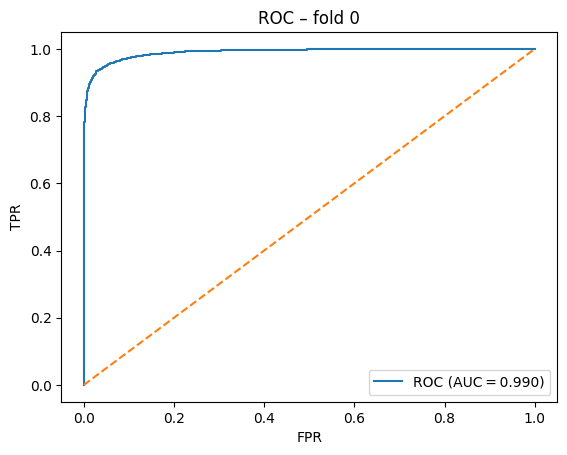

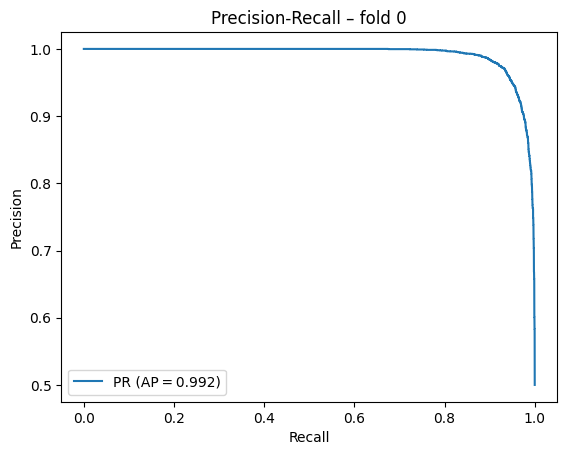

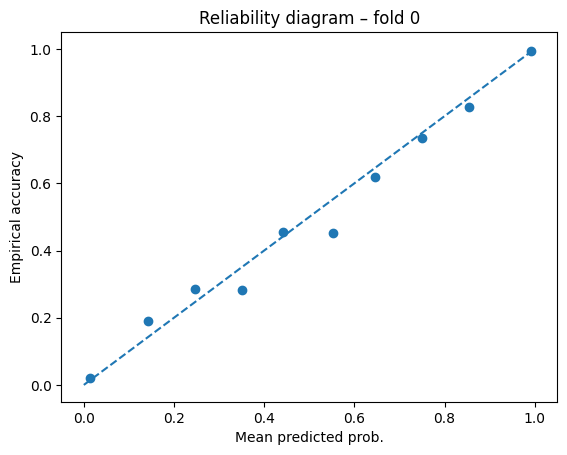

In [ ]:

# Phase 4 – CV + courbes avec les embeddings déjà en mémoire
# On suppose disponibles : X_tr_lo, X_te_lo, y_tr, y_te
# (ou plus simplement : X_lo = np.vstack([X_tr_lo, X_te_lo]),
#                      y     = np.concatenate([y_tr, y_te]))

import numpy as np, matplotlib.pyplot as plt, torch
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

# 1) Concaténer train+test pour faire une CV homogène
X_lo = np.vstack([X_tr_lo, X_te_lo])
y    = np.concatenate([y_tr,  y_te ])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s, aucs = [], [], []

# Pour les courbes du fold 0
probs0, y0 = None, None

for k, (train_idx, test_idx) in enumerate(skf.split(X_lo, y)):
    clf = LogisticRegression(max_iter=1000, C=1.0).fit(X_lo[train_idx], y[train_idx])
    y_pred = clf.predict(X_lo[test_idx])
    y_prob = clf.predict_proba(X_lo[test_idx])[:, 1]

    accs.append(accuracy_score(y[test_idx], y_pred))
    f1s.append( f1_score(y[test_idx], y_pred) )
    fpr, tpr, _ = roc_curve(y[test_idx], y_prob)
    aucs.append( auc(fpr, tpr) )

    if k == 0:  probs0, y0 = y_prob, y[test_idx]

print(f"Accuracy CV : {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"F1‑score CV : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"AUC‑ROC CV  : {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# 2) Courbe ROC + PR + calibration pour le fold 0
fpr0, tpr0, _ = roc_curve(y0, probs0)
prec0, rec0, _ = precision_recall_curve(y0, probs0)
ap0 = average_precision_score(y0, probs0)

plt.figure()
plt.plot(fpr0, tpr0, label=f"ROC (AUC = {auc(fpr0, tpr0):.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – fold 0"); plt.legend(); plt.show()

plt.figure()
plt.plot(rec0, prec0, label=f"PR (AP = {ap0:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision‑Recall – fold 0"); plt.legend(); plt.show()

bins = np.linspace(0,1,11);  binids = np.digitize(probs0, bins)-1
conf, acc = [], []
for b in range(10):
    idx = binids==b
    if idx.sum()==0: continue
    conf.append(probs0[idx].mean()); acc.append(y0[idx].mean())
plt.figure()
plt.plot([0,1],[0,1],"--"); plt.scatter(conf, acc)
plt.xlabel("Mean predicted prob."); plt.ylabel("Empirical accuracy")
plt.title("Reliability diagram – fold 0"); plt.show()


### Summary of **Phase 4 – In-Depth Evaluation**

|  Metric (5-fold CV)  |  Mean    |  Std Dev  |
|----------------------|:--------:|:---------:|
| Accuracy             | **0.9519** |  0.0016  |
| Macro-F1             | **0.9517** |  0.0016  |
| ROC-AUC              | **0.9906** |  0.0006  |

#### Quick Takeaways

* **Stability**: very low inter-fold variance (±0.16 %), indicating a consistent model.  
* **Discrimination**: AUC ≈ 0.991 → excellent separation of human vs. LLM text.  
* **Precision–Recall curve**: AP ≈ 0.992, almost flat above 0.99 up to 90 % recall, meaning very few false-positives.  
* **Calibration**: reliability diagram stays close to the diagonal, with a slight under-confidence in the mid-range bins (predicted probabilities ≈ 0.3–0.6).  

#### Phase 4 Conclusion

The **LoRA-merged + Logistic Regression** pipeline demonstrates:

1. **Excellent performance** (~ 95 % Acc/F1) on a large, balanced hold-out.  
2. **High statistical robustness** (std dev < 0.2 %).  
3. **Reasonably calibrated probabilities**, with room for improvement.



## Saving the embedding + LR model and label prediction function

In [ ]:
# **Pré‑requis déjà en mémoire**  
# - `lora_merged`  : modèle XLM‑R + LoRA fusionné, en mode `.eval()`
# - `tokenizer`    : tokenizer XLM‑R
# - `X_tr_lo`, `y_tr` : embeddings CLS (train) et labels
#
# La cellule :
# 1. entraîne le `LogisticRegression` si ce n’est pas déjà fait ;
# 2. le sauvegarde en `outputs/gpt2-finetuned-full/lr_clf.joblib` ;
# 3. définit `predict_with_lr(text)` qui :
#    * extrait l’embedding CLS du texte ;
#    * renvoie le label (0=Humain, 1=GPT‑2) + proba.

import os, joblib, torch, numpy as np
from sklearn.linear_model import LogisticRegression

# 1) Où sauvegarder
lr_path = "outputs/gpt2-finetuned-full/lr_clf.joblib"

# 2) (Ré)entraîner si besoin
if os.path.exists(lr_path):
    lr_clf = joblib.load(lr_path)
    print("LR chargé depuis le disque.")
else:
    print("Entraînement du Logistic Regression…")
    lr_clf = LogisticRegression(max_iter=1000, C=1.0).fit(X_tr_lo, y_tr)
    joblib.dump(lr_clf, lr_path)
    print(f"LR sauvegardé → {lr_path}")

label_map = {0: "Humain", 1: "GPT‑2 / LLM"}

# 3) Fonction de prédiction end‑to‑end
def predict_with_lr(text:str):
    """Prédit le label via (tokenizer → lora_merged → embedding CLS) → LR."""
    enc = tokenizer(text, truncation=True, padding=True,
                    return_tensors="pt").to(lora_merged.device)
    with torch.no_grad():
        cls = lora_merged.roberta(**enc).last_hidden_state[:,0,:].cpu().numpy()
    prob = lr_clf.predict_proba(cls)[0,1]
    label = 1 if prob >= 0.5 else 0
    return label_map[label], prob


demo = "This answer was definitely written by a human being."
lbl, p = predict_with_lr(demo)
print(f"Texte : {demo}\n→ LR : {lbl} (p_GPT2 = {p:.3f})")



Entraînement du Logistic Regression…
LR sauvegardé → outputs/gpt2-finetuned-full/lr_clf.joblib
Texte : This answer was definitely written by a human being.
→ LR : GPT‑2 / LLM (p_GPT2 = 0.960)
